In [1]:
import torch
import csv
import numpy as np


import torch.utils.data as utils
from torch import nn, optim
import torch.nn.functional as F


import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [2]:
PitchClass =[  # The order of these files need to be the same
    'Pitched_Amplitude.csv',
    'Pitched_Frequency.csv',
    'Pitched_SensoryDissonance.csv',
    'Pitched_SpectralEntropy.csv'   
]
TimbralClass = [
   'Timbral_Amplitude.csv',
    'Timbral_Frequency.csv',
    'Timbral_SensoryDissonance.csv',
    'Timbral_SpectralEntropy.csv'   
]

In [3]:
def LoadCSVs(CSVFileArray):
    OutPutArray=[]
    for csvFile in CSVFileArray:
        TempArray=[]
        with open(csvFile, newline='') as TheFile:
            fileReader = csv.reader(TheFile, delimiter=',' )
            for row in fileReader:
                TempArray.append(np.float64(row[0]))
        OutPutArray.append(TempArray)
    return np.array(OutPutArray).T
print(LoadCSVs(TimbralClass))

[[1.21900e-02 4.40000e+02 0.00000e+00 0.00000e+00]
 [5.56931e-03 2.10283e+04 0.00000e+00 5.32513e+01]
 [5.93050e-03 2.10699e+04 0.00000e+00 8.66560e+01]
 ...
 [3.53296e-01 4.40265e+02 5.82047e+01 2.09007e+00]
 [1.49441e-01 4.38142e+02 3.16227e+00 4.08216e+00]
 [2.39323e-02 4.38142e+02 0.00000e+00 7.80765e+01]]


In [4]:
TimbralData = LoadCSVs(TimbralClass)
PitchData = LoadCSVs(PitchClass)

ShortesLength = min(len(TimbralData),len(PitchData))
TimbralData=TimbralData[:ShortesLength]
PitchData=PitchData[:ShortesLength]


In [5]:
CompleteInputData = np.concatenate((TimbralData, PitchData), axis=0)
classes=['TimbralData','PitchData']

In [6]:
torch.cat((torch.zeros(1),torch.ones(5))).long()

tensor([0, 1, 1, 1, 1, 1])

In [7]:
tensor_x = torch.stack([torch.Tensor(i) for i in CompleteInputData]) # transform to torch tensors
tensor_y = torch.cat((torch.zeros(len(TimbralData)),torch.ones(len(PitchData)))).long()
tensor_y.long()
print(tensor_x.shape,tensor_y.shape)

my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset

train_size = int(0.8 * len(my_dataset))
test_size = len(my_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [train_size, test_size])
my_trainloader = utils.DataLoader(train_dataset,batch_size=16,shuffle=True) 
my_testloader = utils.DataLoader(test_dataset,batch_size=16,shuffle=False) 

torch.Size([1346, 4]) torch.Size([1346])


In [8]:
InputSize = tensor_x.shape[1]
NumberOfClasses = len(classes)

print("Input size (number of variables) should be:",InputSize)

Input size (number of variables) should be: 4


In [9]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork,self).__init__()
        
        self.hiddenLayerSize=64
        self.hiddenLayerSize2=10
        
        self.bn0 = nn.BatchNorm1d(InputSize)
        self.fc0 = nn.Linear(InputSize, self.hiddenLayerSize)
        self.fc1 = nn.Linear(self.hiddenLayerSize,self.hiddenLayerSize2) 
        self.fc2 = nn.Linear(self.hiddenLayerSize2,NumberOfClasses) 
        
        

    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''   
        x = self.bn0(x)
        x = self.fc0(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x)
    
        return x

In [10]:
model = SimpleNetwork()
print(model)
model.train()

SimpleNetwork(
  (bn0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=4, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)


SimpleNetwork(
  (bn0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=4, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [12]:
Counter=0;
LossOverEpoch=[]
EvalLoss=[]

In [13]:
RunForNumEpochs=500

In [21]:
for i in range(RunForNumEpochs):
    model.train()
    running_loss=0
    for data, labels in my_trainloader:
        optimizer.zero_grad()    
        result  = model(data)
        loss =criterion(result,labels)
        #print(result)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    model.eval();
    TestLoss=0
    for data, labels in my_testloader:
        result = model(data)  
        loss = criterion(result,labels)
        TestLoss += loss.item()
    LossOverEpoch.append(running_loss/len(my_trainloader))
    EvalLoss.append(TestLoss/len(my_testloader))
    print(str(f"Training loss: {running_loss/len(my_trainloader)}" +"   "+ str(Counter))+"  "+str(TestLoss/len(my_testloader)))
    Counter+=1

/anaconda3/envs/ImageCalc/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training loss: 0.5770346105975264   1000  0.5549151213730082
Training loss: 0.5708417230669189   1001  0.547576087362626
Training loss: 0.5731095697949914   1002  0.5487956842955422
Training loss: 0.5700101760380408   1003  0.566426694393158
Training loss: 0.5711533146746018   1004  0.553884786718032
Training loss: 0.5724672872354003   1005  0.5501729302546557
Training loss: 0.5742421904030968   1006  0.5542891656651217
Training loss: 0.5675658636233386   1007  0.5547427114318398
Training loss: 0.5641825400731143   1008  0.546841479399625
Training loss: 0.5724191556082052   1009  0.5484809963142171
Training loss: 0.572867214679718   1010  0.5526275739950293
Training loss: 0.5635797078995144   1011  0.5588614221881417
Training loss: 0.5550644502920263   1012  0.5522581181105446
Training loss: 0.5652862800394788   1013  0.5638207933482002
Training loss: 0.5680288177202729   1014  0.5381544407676248
Training loss: 0.5664420785272822   1015  0.5682346663054298
Training loss: 0.582641476217

Training loss: 0.5651240550419864   1137  0.5430360313724069
Training loss: 0.5700223748298252   1138  0.5571224128498751
Training loss: 0.5698948844390757   1139  0.5527047690223245
Training loss: 0.5705860520110411   1140  0.5387052402776831
Training loss: 0.5752159212442005   1141  0.5450368471005383
Training loss: 0.5765909754178103   1142  0.5636202868293313
Training loss: 0.5702707320451736   1143  0.5601849608561572
Training loss: 0.5595709554412786   1144  0.5386994954417733
Training loss: 0.5635244500111131   1145  0.5532715338117936
Training loss: 0.5611906871199608   1146  0.547157899421804
Training loss: 0.5631915523725397   1147  0.5618941328104805
Training loss: 0.5728879987316973   1148  0.5494609054397134
Training loss: 0.5648632465916521   1149  0.5434403156532961
Training loss: 0.5531502234585145   1150  0.5722886516767389
Training loss: 0.5672003894167787   1151  0.5484053737976972
Training loss: 0.5713534447200158   1152  0.5538614497465246
Training loss: 0.56032891

Training loss: 0.564115075942348   1272  0.5428538217264063
Training loss: 0.5732219683773377   1273  0.5607126074678758
Training loss: 0.5768508893602035   1274  0.5592284833683687
Training loss: 0.5727949440479279   1275  0.5415915040408864
Training loss: 0.5747634268858853   1276  0.5571679718354169
Training loss: 0.5665828384020749   1277  0.5643285267493304
Training loss: 0.5525654681465205   1278  0.5325451090055353
Training loss: 0.5649439867805032   1279  0.5396867411978105
Training loss: 0.5659923365010935   1280  0.5453457832336426
Training loss: 0.5723565453115631   1281  0.5459292005090153
Training loss: 0.5733939707279205   1282  0.5521724329275244
Training loss: 0.5687978881246903   1283  0.5514445971040165
Training loss: 0.5709361407686683   1284  0.5527408578816582
Training loss: 0.5554664143744636   1285  0.535446764791713
Training loss: 0.5671476520159665   1286  0.535730440826977
Training loss: 0.5661980145994354   1287  0.5554964402142692
Training loss: 0.5595154643

Training loss: 0.5514005930984721   1407  0.5530444664113662
Training loss: 0.5631658807396889   1408  0.5328707063899321
Training loss: 0.5801025686018607   1409  0.5359170805005466
Training loss: 0.5689249152646345   1410  0.5535138161743388
Training loss: 0.5593134717029684   1411  0.5438315359985127
Training loss: 0.5697425840532079   1412  0.5420027462875142
Training loss: 0.5790421195766505   1413  0.5328402782187742
Training loss: 0.5765010420890415   1414  0.5358223757323097
Training loss: 0.5573751957100981   1415  0.5389992138918709
Training loss: 0.5731712781331119   1416  0.5276897199013654
Training loss: 0.5757173413739485   1417  0.5417546331882477
Training loss: 0.5682214239940924   1418  0.5629317725405973
Training loss: 0.5698680040590903   1419  0.5711942385224735
Training loss: 0.5728972856612766   1420  0.5364823183592629
Training loss: 0.5797422690426602   1421  0.5491470957503599
Training loss: 0.5575906476553749   1422  0.5872016303679523
Training loss: 0.5669265

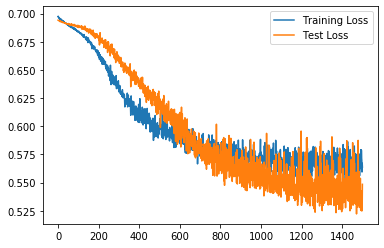

In [22]:
plt.plot(LossOverEpoch,label='Training Loss')
plt.plot(EvalLoss,label='Test Loss')
plt.legend()
plt.show()

In [23]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model.eval()
allLabels=[]
allPrediction=[]
with torch.no_grad():
    for data in my_testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if (c.dim()==0):
            continue
        for i in range(my_testloader.batch_size):
            if(len(labels)<=i):
                continue;
            label = labels[i]
            allLabels.append(labels[i].to('cpu').numpy())
            allPrediction.append(predicted[i].to('cpu').numpy())
            if(my_testloader.batch_size>1):
                class_correct[label] += c[i].item()
            else:
                class_correct[label] += c.item()
            class_total[label] += 1

print(confusion_matrix(allLabels, allPrediction))
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

[[101  29]
 [ 19 121]]
Accuracy of TimbralData : 77 %
Accuracy of PitchData : 86 %


/anaconda3/envs/ImageCalc/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
